A quick tutorial showing the features of BoNesis for the synthesis of Most Permissive Boolean Networks from network architecture and dynamical constraints.

In [12]:
import os
import bonesis
import pandas as pd
from colomoto_jupyter import tabulate

The synthesis uses two inputs:
1. the domain of BNs, which can be a single BN, or specified by an influence graph
2. a table (dictionnary) specifying the (partial) observations of the systems

## Synthesis from influence graph and dynamical constraints

### Influence graph

Let us define an influence graph from a list of pairwise interactions, with a sign.

In [13]:
influences = [
("Pax6","Pax6",dict(sign=1)),
("Pax6","Hes5",dict(sign=1)),
("Pax6","Mash1",dict(sign=1)),
("Hes5","Mash1",dict(sign=-1)),
("Hes5","Scl",dict(sign=1)),
("Hes5","Olig2",dict(sign=1)),
("Hes5","Stat3",dict(sign=1)),
("Mash1","Hes5",dict(sign=-1)),
("Mash1","Zic1",dict(sign=1)),
("Mash1","Brn2",dict(sign=1)),
("Zic1","Tuj1",dict(sign=1)),
("Brn2","Tuj1",dict(sign=1)),
("Scl","Olig2",dict(sign=-1)),
("Scl","Stat3",dict(sign=1)),
("Olig2","Scl",dict(sign=-1)),
("Olig2","Myt1L",dict(sign=1)),
("Olig2","Sox8",dict(sign=1)),
("Olig2","Brn2",dict(sign=-1)),
("Stat3","Aldh1L1",dict(sign=1)),
("Myt1L","Tuj1",dict(sign=1)),
]

# computing graph layout...


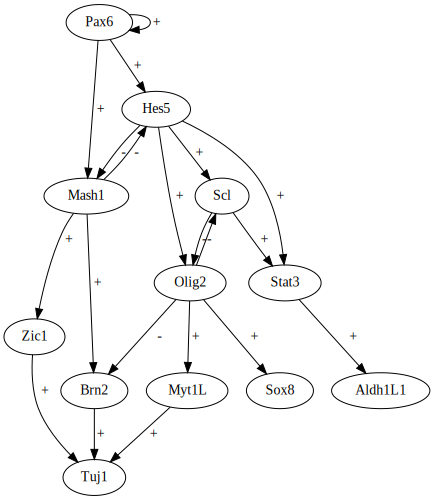

In [14]:
dom1 = bonesis.InfluenceGraph(influences)
dom1

Here, `dom1` delimits any BN that uses *at most* the listed influences, with the right sign. Thus, some solutions may use only a subset of this influence graph.

If you want to enforce BNs using *all* the given influences, use the option `exact=True`:

# computing graph layout...


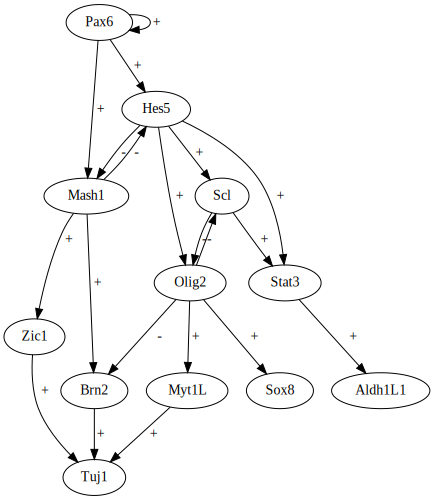

In [15]:
dom2 = bonesis.InfluenceGraph(influences, exact=True)
dom2

For influence graphs with large in-degrees, it is necessary to specify a bound on the number of clauses in the disjunction normal form (DNF) of the BNs with the `maxclause` argument. See `help(bonesis.InfluenceGraph)` for other options.

### Observations

They are specified by a Python dictionnary associating observation names to observed states of a subset of nodes:

In [16]:
data = {
    "zero": {n: 0 for n in dom1}, # all nodes are 0
    "init": {n: 1 if n == "Pax6" else 0 for n in dom1}, # all nodes are 0 but Pax6
    "tM": {"Pax6": 1, "Tuj1": 0, "Scl": 0, "Aldh1L1": 0, "Olig2": 0, "Sox8": 0},
    "fT": {"Pax6": 1, "Tuj1": 1, "Brn2": 1, "Zic1": 1, "Aldh1L1": 0, "Sox8": 0},
    "tO": {"Pax6": 1, "Tuj1": 0 ,"Scl": 0, "Aldh1L1": 0, "Olig2": 1, "Sox8": 0},    
    "fMS": {"Pax6": 1, "Tuj1": 0, "Zic1": 0, "Brn2": 0, "Aldh1L1": 0, "Sox8": 1},
    "tS": {"Pax6": 1, "Tuj1": 0, "Scl": 1, "Aldh1L1": 0, "Olig2": 0, "Sox8": 0},
    "fA": {"Pax6": 1, "Tuj1": 0, "Zic1": 0, "Brn2": 0, "Aldh1L1": 1, "Sox8": 0},
}
pd.DataFrame.from_dict(data, orient="index").fillna('')

,Pax6,Hes5,Mash1,Scl,Olig2,Stat3,Zic1,Brn2,Tuj1,Myt1L,Sox8,Aldh1L1
zero,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0
init,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0
tM,1,,,0.0,0.0,,,,0,,0,0
fT,1,,,,,,1.0,1.0,1,,0,0
tO,1,,,0.0,1.0,,,,0,,0,0
fMS,1,,,,,,0.0,0.0,0,,1,0
tS,1,,,1.0,0.0,,,,0,,0,0
fA,1,,,,,,0.0,0.0,0,,0,1


## Save models from bonesis as `.bnet`

In [6]:
import mpbn
from zipfile import ZipFile

In [7]:
exact_pkn = False
maxclause =  100
exclude_cyclic = False
bundle_prefix = "bundle-{}pkn{}-{}".format("exact" if exact_pkn else "any", maxclause,
        "nocyclic-" if exclude_cyclic else "")
limit = 30000
threads = 15

In [8]:
# Function to check for cyclic attractor (mpbn)

def has_cyclic(bn):
    mbn = mpbn.MPBooleanNetwork(bn)
    for a in mbn.attractors():
        if "*" in a.values():
            return True
    return False

In [9]:
# Function to write bonesis generated file to `.bnet`

def build_ensemble(bo, name, limit):
    zipfile = f"{bundle_prefix}{name}.zip"
    print(f"Building ensemble of size {limit} in {zipfile}")
    mylimit = 2*limit
    view = bo.diverse_boolean_networks(limit=mylimit, skip_supersets=False)
    with ZipFile(zipfile, "w") as bundle:
        n = 0
        for i, bn in enumerate(view):
            if exclude_cyclic and has_cyclic(bn):
                print("HAS CYCLIC ATTRACTORS, IGNORING")
                continue
            with bundle.open(f"bn{i}.bnet", "w") as fp:
                fp.write(bn.source().encode())
            n += 1
            if n == limit:
                break


### Note ### 

# I don't understand what is the `superset` in the function `diverse_boolean_networks`
# Will have to ask Loic or probably 

## Dynamical properties

In [10]:
import multiprocessing as mp
import time
from tqdm import tqdm

def write_solution_file(index, solution, previous):
    filename = f"bn_{index}.bnet"
    with open(filename, "w") as file:
        file.write(solution.source())
    previous.append(index)

def write_bn_files(solutions, num_processes = 15, project = "test"):
    # Multiprocessing arg
    manager=mp.Manager()
    previous=manager.list()
    processes=[]

    # Define path
    project_name = project
    os.mkdir(project_name)
    os.chdir(project_name)

    # For loop to write bnet files
    for i in tqdm(range(len(solutions))):
        solution = solutions[i]
        while len(previous)<i-(num_processes-1):
            time.sleep(1)
        p = mp.Process(target = write_solution_file, 
                        args = (i,solution,previous))
        p.start()
        processes.append(p)
    for process in processes:
        process.join()

Constraint - Fx

In [11]:
bo = bonesis.BoNesis(dom1, data)

# Add fixed points
bo.fixed(~bo.obs("fA"))
bo.fixed(~bo.obs("fMS"));
fT_tp = bo.fixed(bo.obs("fT"))

# Add constraints
#~bo.obs("init") >= fT_tp
#~bo.obs("init") >= ~bo.obs("fMS")
#~bo.obs("init") >= ~bo.obs("fA");

# Get the solutions
solutions = list(bo.boolean_networks())

os.chdir("/home/spankaew/Git/BooleanBenchmark/models/dev")
write_bn_files(solutions, num_processes=15, project = "BN_TUTO_Fx")

Grounding...done in 0.0s


100%|██████████| 2240/2240 [00:22<00:00, 99.68it/s] 


Constraint - init + Fx

In [20]:
bo = bonesis.BoNesis(dom1, data)

# Add fixed points
bo.fixed(~bo.obs("fA"))
bo.fixed(~bo.obs("fMS"));
fT_tp = bo.fixed(bo.obs("fT"))

# Add constraints
~bo.obs("init") >= fT_tp
~bo.obs("init") >= ~bo.obs("fMS")
~bo.obs("init") >= ~bo.obs("fA");

# Get the solutions
solutions = list(bo.boolean_networks())

os.chdir("/home/spankaew/Git/BooleanBenchmark/models/dev")
write_bn_files(solutions, num_processes=15, project = "BN_TUTO_init+Fx")

Grounding...done in 0.0s


100%|██████████| 2240/2240 [00:22<00:00, 99.81it/s] 


Constraint - init + t + Fx

In [21]:
bo = bonesis.BoNesis(dom1, data)

# Add fixed points
bo.fixed(~bo.obs("fA"))
bo.fixed(~bo.obs("fMS"));
fT_tp = bo.fixed(bo.obs("fT"))

# Add constraints
~bo.obs("init") >= ~bo.obs("tM") >= fT_tp
~bo.obs("init") >= ~bo.obs("tO") >= ~bo.obs("fMS")
~bo.obs("init") >= ~bo.obs("tS") >= ~bo.obs("fA");

# Get the solutions
solutions = list(bo.boolean_networks())

# Save boolean ensemble
os.chdir("/home/spankaew/Git/BooleanBenchmark/models/dev")
write_bn_files(solutions, num_processes=15, project = "BN_TUTO_init+t+Fx")

Grounding...done in 0.0s


100%|██████████| 2240/2240 [00:18<00:00, 118.07it/s]


Constraint - init + FX + Zero

In [22]:
bo = bonesis.BoNesis(dom1, data)

# Add fixed points
bo.fixed(~bo.obs("fA"))
bo.fixed(~bo.obs("fMS"));
fT_tp = bo.fixed(bo.obs("fT"))

# Add constraints
## Add positive reachability constraints
~bo.obs("init") >= fT_tp
~bo.obs("init") >= ~bo.obs("fMS")
~bo.obs("init") >= ~bo.obs("fA");
## Add negative reachability constraints
~bo.obs("zero") / fT_tp
~bo.obs("zero") / ~bo.obs("fMS")
~bo.obs("zero") / ~bo.obs("fA");

# Get the solutions
solutions = list(bo.boolean_networks())

# Save boolean ensemble
os.chdir("/home/spankaew/Git/BooleanBenchmark/models/dev")
write_bn_files(solutions, num_processes=15, project = "BN_TUTO_init+Fx+Zero")

Grounding...done in 0.0s


100%|██████████| 1120/1120 [00:12<00:00, 87.65it/s]


Constraint - init + t + Fx + Zero

In [23]:
bo = bonesis.BoNesis(dom1, data)

# Add fixed points
bo.fixed(~bo.obs("fA"))
bo.fixed(~bo.obs("fMS"));
fT_tp = bo.fixed(bo.obs("fT"))

# Add constraints
## Add positive reachability constraints
~bo.obs("init") >= ~bo.obs("tM") >= fT_tp
~bo.obs("init") >= ~bo.obs("tO") >= ~bo.obs("fMS")
~bo.obs("init") >= ~bo.obs("tS") >= ~bo.obs("fA");
## Add negative reachability constraints
~bo.obs("zero") / fT_tp
~bo.obs("zero") / ~bo.obs("fMS")
~bo.obs("zero") / ~bo.obs("fA");

# Get the solutions
solutions = list(bo.boolean_networks())

# Save boolean ensemble
os.chdir("/home/spankaew/Git/BooleanBenchmark/models/dev")
write_bn_files(solutions, num_processes=15, project = "BN_TUTO_init+t+Fx+Zero")

Grounding...done in 0.0s


100%|██████████| 1120/1120 [00:12<00:00, 90.19it/s] 


Constraint - init + t + Fx + Zero + UnivConstraints

In [25]:
bo = bonesis.BoNesis(dom1, data)

# Add fixed points
bo.fixed(~bo.obs("fA"))
bo.fixed(~bo.obs("fMS"));
fT_tp = bo.fixed(bo.obs("fT"))

# Add constraints
## Add positive reachability constraints
~bo.obs("init") >= ~bo.obs("tM") >= fT_tp
~bo.obs("init") >= ~bo.obs("tO") >= ~bo.obs("fMS")
~bo.obs("init") >= ~bo.obs("tS") >= ~bo.obs("fA");
## Add negative reachability constraints
~bo.obs("zero") / fT_tp
~bo.obs("zero") / ~bo.obs("fMS")
~bo.obs("zero") / ~bo.obs("fA");
## Add universal constraints
bo.all_fixpoints({bo.obs(obs) for obs in ["fA", "fMS", "fT", "zero"]});
~bo.obs("init") >> "fixpoints" ^ {bo.obs(obs) for obs in ["fA", "fMS", "fT"]};

# Get the solutions
solutions = list(bo.boolean_networks())

# Save boolean ensemble
os.chdir("/home/spankaew/Git/BooleanBenchmark/models/dev")
write_bn_files(solutions, num_processes=15, project = "BN_TUTO_init+t+Fx+Zero+UnivConstraints")

Grounding...done in 0.1s


100%|██████████| 88/88 [00:01<00:00, 66.38it/s]
